# Linear image classification

For the purpose of this example, we will classify the data provided by Maryana. A reminder: these are RGB images that belong to one of three classes

We'll start with a simple model linear classifier. As we saw before, this kind of classifier will do poorly in cases in which the data cannot be separated with hyper-planes through the space defined by the data. Still, it will be a good first stab at this, because some of the patterns of using TF will be easier to explain

In [1]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

First, we need a function that will read the `tfrecords` file that we created in [`002-create-tfrecords`](002-create-tfrecords.ipynb). This function will do some rather elaborate magic under the hood to keep the data streaming through the computation graph. Importantly, it returns only a notional answer -- the `label` and `image` created here need to be computed as part of a TF session, so everything gets populated within the graph at run time.

In [3]:
def read_and_decode(filename):
    filename_queue = tf.train.string_input_producer([filename],
                                                    num_epochs=None)

    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(
        serialized_example,
        features={
                'image/height': tf.FixedLenFeature([], tf.int64),
                'image/width': tf.FixedLenFeature([], tf.int64),
                'image/depth': tf.FixedLenFeature([], tf.int64),
                'label': tf.FixedLenFeature([], tf.int64),
                'image/raw': tf.VarLenFeature(tf.string)})

    # Shape elements must be int32 tensors!
    height = tf.cast(features['image/height'], tf.int32)
    width = tf.cast(features['image/width'], tf.int32)
    depth = tf.cast(features['image/depth'], tf.int32)
    
    # Decode the image from its raw representation:
    image = tf.decode_raw(features['image/raw'].values, tf.uint8)

    # Reshape it back to its original shape:
    im_shape = tf.pack([height, width, depth])
    image = tf.reshape(image, im_shape)
    #tf.random_crop(image, [height, width, depth])
    # Convert from [0, 255] -> [0, 1] floats.
    image = tf.cast(image, tf.float32) * (1. / 255)

    # Convert label from a scalar uint8 tensor to an int32 scalar.
    label = tf.cast(features['label'], tf.int32)
    return image, label

This is how this function can be used. Notice how fast it runs! This is because it only demarcates the variables, without reading any data into memory. This will only happen when the variables are initialized in the context of a session and run. 

In [4]:
image, label = read_and_decode(op.expanduser(op.join('~', 'data_ucsf','cells_train.tfrecords')))

For example, here we start a session, initialize all the variables, start queues and run image and label once. This is tantamount to pulling out the first value from the tfrecords file:

In [5]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
tf.train.start_queue_runners(sess=sess)
im_1, lab_1 = sess.run([image, label])

In [6]:
im_1.shape

(256, 256, 3)

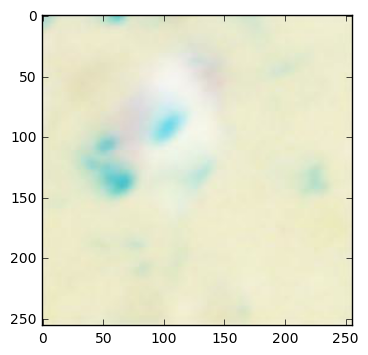

In [7]:
plt.imshow((im_1 * 255).astype(int), vmin=0, vmax=255)

In [8]:
lab_1

1

Again, this happens quite quickly, because only one instance of an image/label pair gets read and decoded in each call to `run`.

Below, we set up training. The function `train.shuffle_batch` is going to do the magic of pulling out examples from the training data. Each batch will have 40 examples. 

W and b are the model parameters (weights and bias). We define the loss function to be a cross-entropy 

Note that we *do not* pass the maximized `y_pred` into the `sparse_softmax_cross_entropy_with_logits`, because it does a softmax operation internally to derive the predicted class.

We calculate a mean loss, that we will use to keep track of what happened during training. Finally, we define an optimizer that will operate on these variables.

In [9]:
# get single examples
image, label = read_and_decode(op.expanduser(op.join('~', 'data_ucsf','cells_train.tfrecords')))

# The following groups the examples into batches randomly. This function requires explicitely setting the
# Shapes of the inputs, so we take advantage of the fact that we already pulled out one example above
images_batch, labels_batch = tf.train.shuffle_batch(
    [image, label], batch_size=40,
    capacity=400,
    shapes=(im_1.shape, lab_1.shape),
    min_after_dequeue=200)

# The model: y_pred = Wx + b
W = tf.Variable(tf.zeros([np.prod(im_1.shape), 3]))
b = tf.Variable(tf.zeros([3]))

y_pred = tf.matmul(tf.reshape(images_batch, [-1, np.prod(im_1.shape)]), W) + b
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(y_pred, labels_batch)

# We can use this for monitoring:
loss_mean = tf.reduce_mean(loss)

# This is an optimizer that will be used for training:
train_op = tf.train.AdamOptimizer().minimize(loss)

Before we start doing anything, we need to also define how we will use other data sets as well. Here, we define the calculation we'll do with the evaluation data.

In [10]:
# These variables are used for evaluation (helping to decide when to stop training):
image_eval, label_eval = read_and_decode(op.expanduser(op.join('~', 'data_ucsf', 'cells_eval.tfrecords')))

# We use a different batch of 40 every time: 
images_eval_batch, labels_eval_batch = tf.train.batch(
            [image_eval, label_eval], batch_size=40,
            shapes=(im_1.shape, lab_1.shape))

y_pred_eval = tf.matmul(tf.reshape(images_eval_batch, [-1, np.prod(im_1.shape)]), W) + b

correct_prediction_eval = tf.reduce_mean(
    tf.cast(
        tf.equal(
            tf.cast(
                tf.argmax(y_pred_eval, 1), tf.int32), labels_eval_batch), 
            tf.float32))

And we'll also need the test data eventually:

In [11]:
# These will be used for a final test:
image_test, label_test = read_and_decode(op.expanduser(op.join('~', 'data_ucsf', 'cells_test.tfrecords')))

# Take the whole set:
images_test_batch, labels_test_batch = tf.train.batch(
            [image_test, label_test], batch_size=169,
            shapes=(im_1.shape, lab_1.shape))

y_pred_test = tf.matmul(tf.reshape(images_test_batch, [-1, np.prod(im_1.shape)]), W) + b

correct_prediction_test = tf.reduce_mean(
    tf.cast(tf.equal(tf.cast(tf.argmax(y_pred_test, 1), tf.int32), labels_test_batch), tf.float32))

Now that all the variables have been defined (but not before!), we can initialize everything:

In [12]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
tf.train.start_queue_runners(sess=sess)

[<Thread(Thread-6, started daemon 140142014617344)>,
 <Thread(Thread-7, started daemon 140142006224640)>,
 <Thread(Thread-8, started daemon 140141997831936)>,
 <Thread(Thread-9, started daemon 140141989439232)>,
 <Thread(Thread-10, started daemon 140141981046528)>,
 <Thread(Thread-11, started daemon 140141628749568)>,
 <Thread(Thread-12, started daemon 140141620356864)>]

Let's run training. This is really simple (see below). 

Note that most of the complexity in the code below comes from evaluation and defining a heuristic for stopping

In [13]:
n_iterations = 0
mean_losses = []
mean_evals = []
max_iterations = 5000

while True:    
    # This is where learning actually takes place!
    _, loss_mean_val = sess.run([train_op, loss_mean])
    # Store the loss so we can look at it:
    mean_losses.append(loss_mean_val)
    # Every 10 learning iterations, we consider whether to stop:
    if np.mod(n_iterations, 10) == 0:
        mean_evals.append(sess.run(correct_prediction_eval))
        print("At step %s, mean evaluated accuracy is: %2.2f"%(n_iterations, mean_evals[-1]))
        # But we really only start thinking about stopping 
        # after 2000 iterations:
        if n_iterations > 2000:
            # Here's how we decide whether to keep going, 
            # based on the held-out data:            
            # If you are still improving, relative to recent past keep training:
            if mean_evals[-1] < (np.mean(mean_evals[-10:-1])):
                break

    # If we're still around iterate:
    n_iterations = n_iterations + 1  

    # If you kept going for very long, break anyway:
    if n_iterations > max_iterations:
        break

At step 0, mean evaluated accuracy is: 0.45
At step 10, mean evaluated accuracy is: 0.35
At step 20, mean evaluated accuracy is: 0.62
At step 30, mean evaluated accuracy is: 0.62
At step 40, mean evaluated accuracy is: 0.65
At step 50, mean evaluated accuracy is: 0.57
At step 60, mean evaluated accuracy is: 0.70
At step 70, mean evaluated accuracy is: 0.57
At step 80, mean evaluated accuracy is: 0.75
At step 90, mean evaluated accuracy is: 0.60
At step 100, mean evaluated accuracy is: 0.73
At step 110, mean evaluated accuracy is: 0.77
At step 120, mean evaluated accuracy is: 0.70
At step 130, mean evaluated accuracy is: 0.68
At step 140, mean evaluated accuracy is: 0.55
At step 150, mean evaluated accuracy is: 0.77
At step 160, mean evaluated accuracy is: 0.68
At step 170, mean evaluated accuracy is: 0.57
At step 180, mean evaluated accuracy is: 0.57
At step 190, mean evaluated accuracy is: 0.57
At step 200, mean evaluated accuracy is: 0.77
At step 210, mean evaluated accuracy is: 0.68

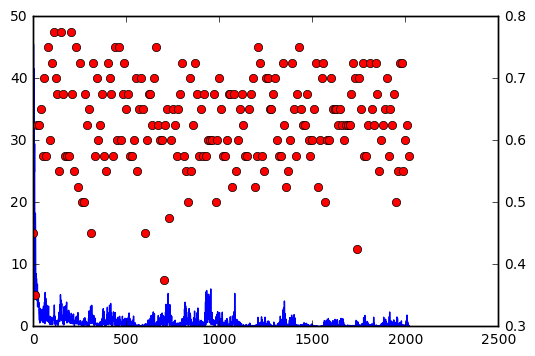

In [14]:
fig, ax = plt.subplots(1)
ax.plot(mean_losses)
ax2 = plt.twinx()
ax2.plot(np.arange(0, n_iterations+1, 10), mean_evals, 'ro')

A few things to notice here: 

- The Adam Optimizer has some interesting behaviors: rather the converging monotonically, it will sometimes try completely different parts of the parameter space, leading to abrupt jumps in the loss function.

- Evaluation with a relatively small number of samples can be rather noisy, leading to difficulty choosing a good stopping criterion.

- If we were doing this in earnest, we might save the parameters during a long training session, and choose the stopping point based on a longer curve. 

- What does it mean when the loss function is rather low, but evaluation is terrible? This might point to over-fitting to the training set. This is why we need an evaluation data-set, rather than relying purely on the loss function as a stopping criterion.


Remember the test set we kept aside? We're going to use that one now to see how well we ultimately did

In [15]:
p = sess.run(correct_prediction_test)

In [16]:
print(p)

0.727811
